In [2]:
import openmeteo_requests
import pandas as pd
import requests
from retry_requests import retry
from pymongo import MongoClient
import matplotlib.pyplot as plt
from datetime import datetime
today_str = datetime.now().strftime('%Y-%m-%d')

In [3]:
client = MongoClient("mongodb://localhost:27017")
db = client["weather_db"]
collection = db["new_york_hourly"]

In [4]:
retry_session = retry(requests.Session(), retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

In [5]:
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 40.7143,
    "longitude": -74.006,
    "start_date": "2024-01-01",
    "end_date": today_str,
    "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "surface_pressure", "wind_speed_10m", "precipitation"],
    "timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)


In [6]:
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")
print(f"Timezone: {response.Timezone()}{response.TimezoneAbbreviation()}")

Coordinates: 40.738136291503906°N -74.04254150390625°E
Elevation: 51.0 m asl
Timezone difference to GMT+0: -18000s
Timezone: b'America/New_York'b'GMT-5'


In [7]:
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(5).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(6).ValuesAsNumpy()

data = {"date": pd.date_range(
    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=hourly.Interval()),
    inclusive="left"
)}

data["temperature"] = hourly_temperature_2m
data["relative_humidity"] = hourly_relative_humidity_2m
data["dew_point"] = hourly_dew_point_2m
data["apparent_temperature"] = hourly_apparent_temperature
data["surface_pressure"] = hourly_surface_pressure
data["wind_speed"] = hourly_wind_speed_10m
data["precipitation"] = hourly_precipitation

df = pd.DataFrame(data=data)
df.head()

,date,temperature,relative_humidity,dew_point,apparent_temperature,surface_pressure,wind_speed,precipitation
0,2024-01-01 05:00:00+00:00,1.5725,75.576317,-2.2775,-2.170197,1009.878906,8.854829,0.0
1,2024-01-01 06:00:00+00:00,2.5725,74.100571,-1.5775,-1.443657,1009.901978,11.384198,0.0
2,2024-01-01 07:00:00+00:00,2.6725,74.391296,-1.4275,-1.076073,1010.003662,9.693296,0.0
3,2024-01-01 08:00:00+00:00,2.5225,75.741234,-1.3275,-0.978189,1009.801453,8.089993,0.0
4,2024-01-01 09:00:00+00:00,0.4725,88.367355,-1.2275,-2.930896,1009.555237,7.517021,0.0


In [8]:
df = df.round({
    'temperature': 4,
    'relative_humidity': 4,
    'dew_point': 4,
    'apparent_temperature': 4,
    'surface_pressure': 4,
    'wind_speed': 4
})
df.head()

,date,temperature,relative_humidity,dew_point,apparent_temperature,surface_pressure,wind_speed,precipitation
0,2024-01-01 05:00:00+00:00,1.5725,75.576302,-2.2775,-2.1702,1009.878906,8.8548,0.0
1,2024-01-01 06:00:00+00:00,2.5725,74.100601,-1.5775,-1.4437,1009.901978,11.3842,0.0
2,2024-01-01 07:00:00+00:00,2.6725,74.391296,-1.4275,-1.0761,1010.003723,9.6933,0.0
3,2024-01-01 08:00:00+00:00,2.5225,75.741203,-1.3275,-0.9782,1009.801514,8.0900,0.0
4,2024-01-01 09:00:00+00:00,0.4725,88.367401,-1.2275,-2.9309,1009.555176,7.5170,0.0


In [9]:
df.to_csv('load.csv')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16704 entries, 0 to 16703
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   date                  16704 non-null  datetime64[ns, UTC]
 1   temperature           16704 non-null  float32            
 2   relative_humidity     16704 non-null  float32            
 3   dew_point             16704 non-null  float32            
 4   apparent_temperature  16704 non-null  float32            
 5   surface_pressure      16704 non-null  float32            
 6   wind_speed            16704 non-null  float32            
 7   precipitation         16704 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(7)
memory usage: 587.4 KB


In [11]:
df.describe()

,temperature,relative_humidity,dew_point,apparent_temperature,surface_pressure,wind_speed,precipitation
count,16704.000000,16704.000000,16704.000000,16704.000000,16704.000000,16704.000000,16704.000000
mean,13.198898,67.481773,6.666870,11.514793,1010.314636,11.159804,0.139254
std,10.096831,19.019745,9.926589,12.419974,7.692762,6.079874,0.739737
min,-16.877501,15.098300,-22.227501,-21.511600,976.630981,0.000000,0.000000
25%,5.222500,52.498673,-0.377500,1.504550,1005.903183,6.720500,0.000000
50%,13.922500,67.983700,7.672500,11.820950,1010.285400,10.094500,0.000000
75%,21.322500,83.683226,14.622500,21.397650,1015.214401,14.650900,0.000000
max,40.172501,100.000000,24.572500,44.308800,1042.469604,57.295399,19.799999


In [12]:
collection.delete_many({})
records = df.to_dict(orient="records")
if records:
    collection.insert_many(records)
else:
    print("No data to insert")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_356\3655235645.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[['temperature', 'relative_humidity', 'dew_point', 'apparent_temperature', 'surface_pressure', 'wind_speed', 'precipitation']].plot.line(subplots=True, ax=ax)


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

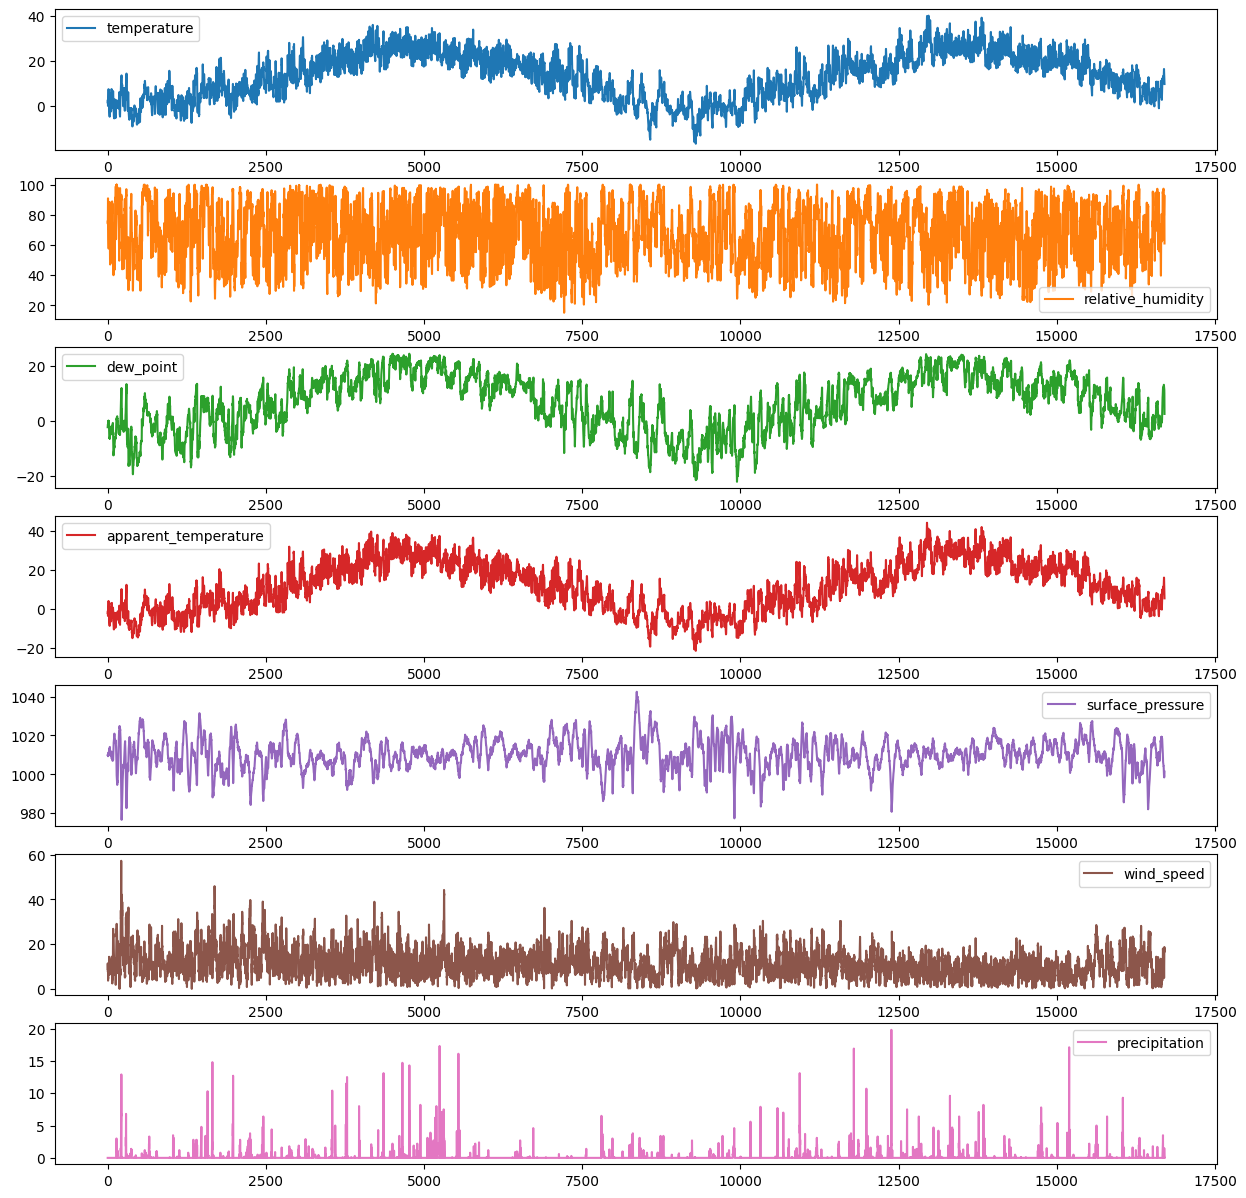

In [13]:
fig, ax = plt.subplots(figsize=(15, 15))
df[['temperature', 'relative_humidity', 'dew_point', 'apparent_temperature', 'surface_pressure', 'wind_speed', 'precipitation']].plot.line(subplots=True, ax=ax)